In [ ]:
#  Steps of the work:

# Make a model with accessible parameters using TensorFlow 2.x
# Write an entropy loss and add it to the network parameters for training.
# Train a model by jointly optimizing its loss (e.g. cross entropy for classification) and the entropy for compressability.
# Compress the model parameters using Huffman coding.
# Analyze the results and trade-off between accuracy and compressability.
# Write a model wrapper that can read and write the compressed parameters.

# Notes:

# Can be started on simple datasets like MNIST.
# Can start from simple MLP NNs. And then extend to convs. The implementation should be generic enough so that it can support any layer.
# Bonus: add support for normalization layers: batch norm, instance norm, etc.

In [1]:
# Load MNIST data set

from tensorflow.keras.datasets import mnist
train_set, test_set = mnist.load_data()

In [3]:
# import os
# os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3' 
# Allocation of 17179869184 exceeds 10% of free system memory.

In [2]:
# generate a simple NN model

from tensorflow.keras.layers import Dense, Input, Flatten
from tensorflow.keras.models import Model
import tensorflow as tf
from tensorflow import keras
import numpy as np

    
kernel_initializer = 'he_normal'
activation = "relu"

def get_model(chs=256):
    shape=(28,28,1)
    
    inputs = Input(shape)
    layer = Flatten()(inputs)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    layer = Dense(units=chs, activation=activation, kernel_initializer=kernel_initializer)(layer)
    output = Dense(10, activation='linear', use_bias=True, kernel_initializer=kernel_initializer)(layer)

    model = Model(inputs, output)
    return model



In [1]:
# model.layers

In [23]:
# model.layers[0]

In [5]:
# model.trainable_variables

In [97]:
# tf.reduce_sum(np.arange(100).reshape((10,10)), axis=0, keepdims=True)



<tf.Tensor: shape=(1, 10), dtype=int64, numpy=array([[450, 460, 470, 480, 490, 500, 510, 520, 530, 540]])>

In [ ]:
# huffman code
class HuffmanNode:
    def __init__(self, freq, value=None):
        self.freq = freq
        self.value = value
        self.left = None
        self.right = None

    def __lt__(self, other):
        return self.freq < other.freq

def build_huffman_tree(frequencies):
    pq = [HuffmanNode(freq, value) for value, freq in frequencies.items()]
    heapq.heapify(pq)

    while len(pq) > 1:
        left = heapq.heappop(pq)
        right = heapq.heappop(pq)
        parent = HuffmanNode(left.freq + right.freq)
        parent.left = left
        parent.right = right
        heapq.heappush(pq, parent)

    return pq[0]

def generate_huffman_codes(node, prefix="", codes={}):
    if node.value is not None:
        codes[node.value] = prefix
    else:
        generate_huffman_codes(node.left, prefix + "0", codes)
        generate_huffman_codes(node.right, prefix + "1", codes)

def compress_activations(activations):
    flat_activations = activations.flatten()
    frequencies = defaultdict(int)
    for value in flat_activations:
        frequencies[value] += 1

    huffman_tree = build_huffman_tree(frequencies)
    huffman_codes = {}
    generate_huffman_codes(huffman_tree, codes=huffman_codes)

    compressed_activations = []
    for value in flat_activations:
        compressed_activations.append(huffman_codes[value])

    return compressed_activations, huffman_codes


# Compress activations
# activations = compNN.get_activations()  # Get activations from the model or compNN
# compressed_activations, huffman_codes = compress_activations(activations)


In [ ]:
# print("")

In [137]:
#     To estimate the histogram, we first remove outliers in the
# activations if the samples are outside the range [μ−3σ; μ+3σ]

def calculate_entropy_range(variables, scale = 3):
    std = tf.math.reduce_variance(variables)**0.5
    if std==0.0:
        std = 1.0
    mean = tf.math.reduce_mean(variables)
    return mean - std*scale, mean + std*scale
    
bins = np.arange(256, dtype=np.float32)
bins = tf.convert_to_tensor(bins)
bins = tf.reshape(bins, (1,-1)) # shape=(1, 256) 0 to 255

#     variables (numpy.ndarray): The variables to calculate the weights for.
#     min_h (float): The minimum value of the histogram bins.
#     max_h (float): The maximum value of the histogram bins.
def calculate_weights(variables, min_h, max_h):
    nbins = 256
    xk = tf.reshape(variables, [-1, 1])  # Reshape variables to a column vector (65536, 1)
#     print("xk")
#     print(xk)
    t = tf.linspace(0, nbins - 1, nbins)
#     print("t")
#     print(t)
    w = weight(xk, t, nbins) # (65536, 256)
#     print("w")
#     print(w)
#     w = tf.reshape(w, [-1, nbins])  # Reshape w back to a 2D tensor(65536, 256)
#     print("aftwer w")
#     print(w)
    deltas = tf.reduce_sum(w, axis=1)  # Compute the sum along the first axis (j)
    print(deltas)
    deltas = tf.reshape(deltas, (-1, 1)) # (65536, 1)?
#     print("deltas")
#     print(deltas)
    
    return deltas

def weight(xk, t, nbins):
    xk = tf.cast(xk, tf.float32)  # Cast xk to float32
    t = tf.cast(t, tf.float32)  # Cast t to float32
    xk = tf.abs(xk - t) / nbins # Compute the absolute difference element-wise
#     print(xk)
    mask = tf.less_equal(xk, 1)  # Create a boolean mask for elements <= 1
    w = tf.where(mask, xk, tf.zeros_like(xk))  # Use the mask to select elements or zeros
    return w

def calculate_histogram(variables, min_h, max_h):
    flat_vars = tf.reshape(variables, (-1,1)) # shape=(65536, 1)
    scaled_vars = (flat_vars-min_h)*255/(max_h-min_h)
    calc_w = calculate_weights(scaled_vars, min_h, max_h)

#     diff = bins - scaled_vars
#     print(bins) # shape = (1,256)
#     print(scaled_vars) # shape=(65536, 1)
#     print(bins - scaled_vars) # shape=(65536, 256)
#     print(bins - diff) # shape=(1, 256)

#     diff = bins - cacl_w
#     p_ = tf.exp(-(diff**2))
#     p = p_ / (tf.reduce_sum(p_, axis=1, keepdims=True)+1e-10)

#     hist = tf.reduce_sum(p, axis=0)

#     sum of calc_w
    
    return calc_w

def calculate_entropy(variables, eps=1e-2):
#     print(variables)
#     variables shape (784, 256)
#     print('gg')
    # TODO implement
    # here you need to also output the range of the compressed data (minimum, maximum)
#     return 0
    # Calculate the histogram of the variables
#     hist, bin_edges = np.histogram(variables, bins='auto')
    
#     # Convert the histogram to probabilities
#     probs = hist / np.sum(hist)
    
#     # Calculate the entropy
#     entropy = -np.sum(probs * np.log2(probs))
    
#     # Calculate the range of the compressed data
#     compressed_range = (bin_edges[0], bin_edges[-1])
# #     print(entropy, '      :::: ', compressed_range)
    
#     return entropy, compressed_range
    flat_vars = tf.reshape(variables, (-1,1))
    min_h, max_h = calculate_entropy_range(variables)
    
    hist = calculate_histogram(flat_vars, min_h, max_h)
    #hist = tf.histogram_fixed_width(flat_vars, [min_h,max_h])
    
    probs = hist / tf.reduce_sum(hist)
#     probs[probs == 0] = 1  # replace zeros with ones
    entropy = -tf.reduce_sum(probs * tf.experimental.numpy.log2(probs+eps))
#     print(entropy,':: ', np.min(flat_vars),':: ', np.max(flat_vars),':: ', bins[0],':: ',bins[1])
    return entropy, (min_h, max_h)

def calc_sparsity_regularization(self, inputs, regularization_coefficient=1e-2):
    abs_inputs = tf.abs(inputs)
    l1_norm = tf.reduce_sum(abs_inputs, axis=0)
    print(tf.shape(inputs))
    num_activations = tf.cast(tf.shape(inputs)[0], dtype=tf.float32)
    regularization_loss = regularization_coefficient / num_activations * tf.reduce_sum(l1_norm)

    
#     flat_vars = tf.reshape(variables, (-1,1))
#     min_h, max_h = calculate_entropy_range(variables)
    
#     hist = calculate_histogram(flat_vars, min_h, max_h)
#     #hist = tf.histogram_fixed_width(flat_vars, [min_h,max_h])
    
#     probs = hist / tf.reduce_sum(hist)
# #     probs[probs == 0] = 1  # replace zeros with ones
#     entropy = -tf.reduce_sum(probs * tf.experimental.numpy.log2(probs+eps))
    
    return regularization_loss

class CompressibleNN(keras.Model):
    def __init__(self, net_model):
        super(CompressibleNN, self).__init__()
        self.net_model = net_model
        self.CE_loss = keras.losses.SparseCategoricalCrossentropy(from_logits=True)

    def call(self, inputs):
        return self.net_model(inputs)
    
    def entropy_loss(self, inputs):
        # TODO implemment the entropy calculation here for each layer parameters
        # for each layer: calculate a histogram and from then calculate the entropy
        # return a sum of all entropies
        
        entropy = 0
#         for l in self.net_model.layers:
#             #TODO: if layer is dense:
#             for v in l.trainable_variables:
#                 # here you have a set of variable for which you can calculate the histogram and entropy
#                 entropy += calculate_entropy(v)
#         return 0
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_entropy, v_range = calculate_entropy(v)
                    entropy += v_entropy

        return entropy
    
    def regularization_loss(self, inputs):
        # TODO implemment the entropy calculation here for each layer parameters
        # for each layer: calculate a histogram and from then calculate the entropy
        # return a sum of all entropies
        
        rg_loss = 0
        
        for l in self.net_model.layers:
            if isinstance(l, keras.layers.Dense):
                for v in l.trainable_variables:
                    v_regularization_loss = calc_sparsity_regularization(v)
                    rg_loss += v_regularization_loss

        return rg_loss
    
    
    def train_step(self, input):
        images = input[0]
        labels = input[1]

        with tf.GradientTape() as tape:
            output = self.net_model(images)
            loss =  self.entropy_loss(images)
#             regularization_loss = self.sparsity_regularization(images)

        # Get the gradients w.r.t the loss
        gradient = tape.gradient(loss, self.net_model.trainable_variables)
        # Update the weights using the generator optimizer
        self.optimizer.apply_gradients(
            zip(gradient, self.net_model.trainable_variables)
        )
        return {"loss": loss}
    
model = get_model()
compNN = CompressibleNN(model)
optimizer = tf.optimizers.Adam(learning_rate=1e-3, beta_1=0.9)
compNN.compile(optimizer, loss=keras.losses.SparseCategoricalCrossentropy(from_logits=True))

In [138]:
# temp = sparsity_regularization(

In [139]:
min_h, max_h = calculate_entropy_range(model.layers[3].variables[0])
our_h=calculate_histogram(model.layers[3].variables[0], min_h, max_h)


tf.Tensor([68.47748  66.39712  65.57054  ... 67.095184 68.65172  71.867096], shape=(65536,), dtype=float32)


In [78]:
np_h=np.histogram(model.layers[3].variables[0], bins=256) # shape 256 * 257
np_h[0]
print(np_h[0].shape)

(256,)


In [104]:
our_h = tf.reshape(our_h,(-1,1))

In [80]:
np_h[0]

array([ 55,  68,  54,  63,  72,  52,  82,  65,  85,  70,  90,  98,  72,
        77,  72,  84,  86, 102, 100, 111,  90, 123, 112, 119, 102, 122,
       128, 132, 138, 138, 139, 149, 154, 150, 138, 162, 145, 160, 171,
       159, 156, 157, 183, 194, 183, 149, 174, 185, 230, 201, 202, 191,
       217, 231, 217, 221, 219, 218, 240, 256, 264, 244, 247, 253, 263,
       278, 249, 270, 259, 295, 285, 287, 286, 310, 309, 291, 285, 351,
       287, 334, 329, 328, 284, 363, 312, 359, 342, 333, 327, 354, 330,
       332, 351, 402, 369, 401, 329, 333, 354, 413, 376, 404, 386, 401,
       426, 372, 404, 425, 423, 397, 466, 427, 425, 389, 479, 436, 442,
       409, 421, 440, 442, 456, 408, 430, 432, 419, 409, 430, 431, 435,
       432, 414, 425, 407, 389, 385, 420, 439, 443, 439, 439, 391, 399,
       461, 435, 418, 394, 403, 408, 423, 382, 387, 403, 379, 407, 390,
       380, 416, 380, 364, 364, 404, 374, 393, 351, 379, 349, 326, 369,
       339, 336, 335, 335, 320, 335, 328, 339, 335, 310, 288, 29

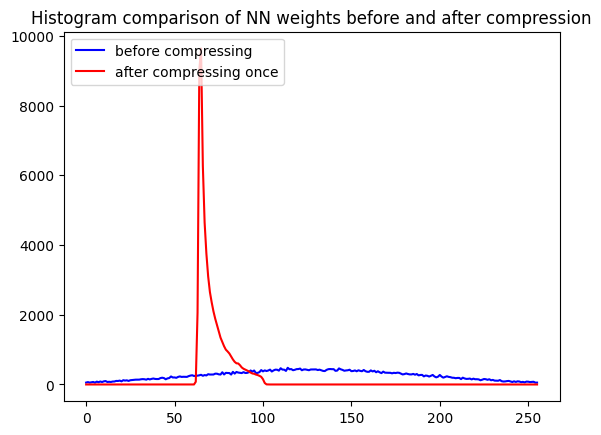

In [131]:
from matplotlib import pyplot as plt
plt.plot(np_h[0], "-b", label="before compressing")
plt.plot(our_h, "-r", label="after compressing once")
plt.legend(loc="upper left")

plt.title("Histogram comparison of NN weights before and after compression")

plt.show()


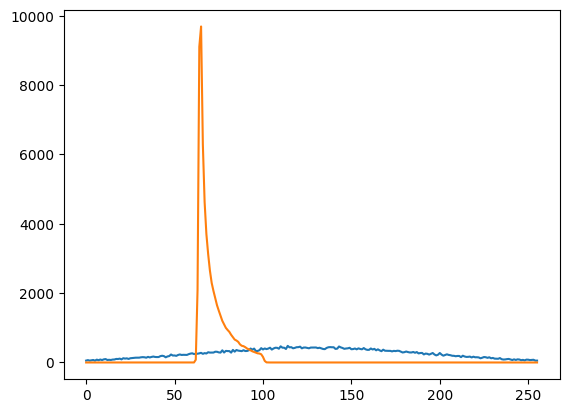

In [87]:
plt.title("Histogram comparison of NN weights before and after compression (initial)")

plt.plot(np_h[0])
plt.plot(our_h)

In [101]:
# train the model
tf.config.run_functions_eagerly(True)
# loss needs to be decreased during training
compNN.fit(x=train_set[0], y=train_set[1], epochs=1, batch_size=32)

   1/1875 [..............................] - ETA: 5:51:51 - loss: 17.8976

KeyboardInterrupt: 

In [53]:
# test performance
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.02000000000001


In [56]:
# test performance with entropy_loss
res = model(test_set[0])
print("test acc: ", 100*(np.argmax(res, axis=1)==test_set[1]).mean())

test acc:  96.61


In [ ]:
 17.7708
 17.7171
 17.6588
 